In [318]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [319]:
campaigns = pd.read_csv('../../data/processed/campaigns.csv')
customers = pd.read_csv('../../data/processed/customer.csv')
engagements = pd.read_csv('../../data/processed/engagement_details.csv')

In [320]:
# Merge the datasets
merged_df = pd.merge(campaigns, engagements, on='campaign_id', how='left')

# Display the first few rows of the merged dataset
print(merged_df.head())

   campaign_id               campaign_type target_audience  campaign_duration  \
0           25  Search Engine Optimization           35-44                 15   
1           25  Search Engine Optimization           35-44                 15   
2           25  Search Engine Optimization           35-44                 15   
3           25  Search Engine Optimization           35-44                 15   
4           25  Search Engine Optimization           35-44                 15   

   conversion_rate  acquisition_cost   roi campaign_language  impressions  \
0           0.1161          16230.45  4.85          Mandarin        14665   
1           0.1161          16230.45  4.85          Mandarin        14665   
2           0.1161          16230.45  4.85          Mandarin        14665   
3           0.1161          16230.45  4.85          Mandarin        14665   
4           0.1161          16230.45  4.85          Mandarin        14665   

   clicks  engagement_id  customer_id channel_used

In [321]:
# Function to calculate the personalisation score
def calculate_personalisation_score(merged_df):
    # Define campaign type weights
    campaign_type_weights = {
        'Search Engine Optimisation': 0.2,
        'Email Marketing': 0.8,
        'Affiliate Marketing': 0.5,
        'Display Advertising': 0.3
    }

    def get_personalisation_score(row):
        # Language score based on campaign language
        language_score = 0.5 if row['campaign_language'] in ['Mandarin', 'French', 'Spanish', 'German'] else 0.3

        # Target audience score based on age group
        if row['target_audience'] == '35-44':
            target_audience_score = 0.7
        elif row['target_audience'] == '55+':
            target_audience_score = 0.6
        else:
            target_audience_score = 0.5

        # Duration score based on campaign duration
        if row['campaign_duration'] > 60:
            duration_score = 0.8
        elif row['campaign_duration'] > 30:
            duration_score = 0.6
        else:
            duration_score = 0.4

        # Campaign type score based on predefined weights
        campaign_type_score = campaign_type_weights.get(row['campaign_type'], 0.4)

        # Calculate the final personalisation score
        personalisation_score = (
            0.25 * campaign_type_score +
            0.2 * language_score + 
            0.25 * target_audience_score +
            0.3 * duration_score
        )

        return personalisation_score

    merged_df['personalisation_score'] = merged_df.apply(get_personalisation_score, axis=1)

    return merged_df

In [322]:
# Functino to calculate the engagement score
def calculate_engagement_score(merged_df):
    # Aggregate engagement data by campaign_id
    campaign_engagements = merged_df.groupby('campaign_id').agg(
        total_engagements=('has_engaged', 'sum'),
        total_duration=('duration', 'sum'),
        impressions=('impressions', 'first')
    ).reset_index()

    # Calculate the engagement rate and effective engagement rate
    campaign_engagements['engagement_rate'] = campaign_engagements['total_engagements'] / campaign_engagements['impressions']
    campaign_engagements['effective_engagement_rate'] = campaign_engagements['total_duration'] / campaign_engagements['impressions']

    # Calculate the final engagement score
    campaign_engagements['engagement_score'] = (
        0.5 * campaign_engagements['engagement_rate'] + 
        0.5 * campaign_engagements['effective_engagement_rate']
    )

    merged_df = pd.merge(merged_df, campaign_engagements[['campaign_id', 'engagement_score']], on='campaign_id', how='left')

    return merged_df

In [323]:
merged_df = calculate_personalisation_score(merged_df)
merged_df = calculate_engagement_score(merged_df)

print(merged_df.head())

   campaign_id               campaign_type target_audience  campaign_duration  \
0           25  Search Engine Optimization           35-44                 15   
1           25  Search Engine Optimization           35-44                 15   
2           25  Search Engine Optimization           35-44                 15   
3           25  Search Engine Optimization           35-44                 15   
4           25  Search Engine Optimization           35-44                 15   

   conversion_rate  acquisition_cost   roi campaign_language  impressions  \
0           0.1161          16230.45  4.85          Mandarin        14665   
1           0.1161          16230.45  4.85          Mandarin        14665   
2           0.1161          16230.45  4.85          Mandarin        14665   
3           0.1161          16230.45  4.85          Mandarin        14665   
4           0.1161          16230.45  4.85          Mandarin        14665   

   clicks  engagement_id  customer_id channel_used

In [324]:
# Preprocess the data
def preprocess_data(df):
    # Encode categorical features using LabelEncoder
    label_encoder = LabelEncoder()
    categorical_features = ['campaign_type', 'campaign_language', 'target_audience']
    
    for col in categorical_features:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Define features (X) and target variable (y)
    X = df[['campaign_type', 'campaign_language', 'target_audience', 'campaign_duration']]
    y = df['personalisation_score']
    
    return X, y, label_encoder

In [325]:
# Train the Random Forest model
def train_personalisation_model(df):
    # Preprocess the data
    X, y, label_encoder = preprocess_data(df)
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the Random Forest Regressor
    personalisation_model = RandomForestRegressor(n_estimators=100, random_state=42)
    personalisation_model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = personalisation_model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Evaluation:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r2}")
    
    return personalisation_model, label_encoder

In [326]:
def predict_personalisation_score(new_campaign_df, personalisation_model, label_encoder):
    # List of categorical features
    categorical_features = ['campaign_type', 'campaign_language', 'target_audience']
    
    # Encode categorical features only (skip numerical columns like 'campaign_duration')
    for col in categorical_features:
        new_campaign_df[col] = label_encoder.fit_transform(new_campaign_df[col])

    # Define the features to be used in the model (keeping numerical columns as they are)
    X_new = new_campaign_df[['campaign_type', 'campaign_language', 'target_audience', 'campaign_duration']]

    # Predict the personalization score using the trained model
    predicted_personalisation_score = personalisation_model.predict(X_new)
    
    return predicted_personalisation_score[0]


In [327]:
personalisation_model, label_encoder = train_personalisation_model(merged_df)

Model Evaluation:
Mean Absolute Error (MAE): 1.4935101766422321e-15
Root Mean Squared Error (RMSE): 1.7935367007669753e-15
R-squared (R²): 1.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [328]:
new_campaign_data = {
    'campaign_type': 'Email Marketing',  # Example new label
    'campaign_language': 'Mandarin',
    'target_audience': '35-44',
    'campaign_duration': 45
}

# Convert the new campaign data to a DataFrame
new_campaign_df = pd.DataFrame([new_campaign_data])

# Predict the personalization score for the new campaign
predicted_personalisation_score = predict_personalisation_score(new_campaign_df, personalisation_model, label_encoder)
print(f"Predicted Personalization Score: {predicted_personalisation_score}")

Predicted Personalization Score: 0.5799999999999992


In [329]:
# Function to preprocess the data (encoding categorical features)
def preprocess_data(df):
    # Instantiate the LabelEncoder
    label_encoder = LabelEncoder()

    # Encode categorical features: campaign_type, campaign_language, target_audience
    categorical_features = ['campaign_type', 'campaign_language', 'target_audience']
    for col in categorical_features:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Define features (X) and target variable (y)
    X = df[['campaign_type', 'campaign_language', 'target_audience', 'campaign_duration']]
    y = df['engagement_score']  # Target variable for engagement score
    
    return X, y, label_encoder

In [330]:
# Function to train the engagement model
def train_engagement_model(df):
    # Preprocess the data (encode categorical features)
    X, y, label_encoder = preprocess_data(df)
    
    # Split data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the RandomForestRegressor model
    engagement_model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Train the model using the training data
    engagement_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = engagement_model.predict(X_test)
    
    # Evaluate the model's performance
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Evaluation:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r2}")
    
    return engagement_model, label_encoder

In [331]:
# Function to predict the engagement score for new campaign data
def predict_engagement_score(new_campaign_df, engagement_model, label_encoder):
    # Encode the categorical features in the new data
    categorical_features = ['campaign_type', 'campaign_language', 'target_audience']
    
    for col in categorical_features:
        new_campaign_df[col] = label_encoder.fit_transform(new_campaign_df[col])

    # Define the features to be used in the model
    X_new = new_campaign_df[['campaign_type', 'campaign_language', 'target_audience', 'campaign_duration']]

    # Predict the engagement score using the trained model
    predicted_engagement_score = engagement_model.predict(X_new)
    
    return predicted_engagement_score[0]

In [332]:
engagement_model, label_encoder = train_engagement_model(merged_df)

Model Evaluation:
Mean Absolute Error (MAE): 0.025171559238096875
Root Mean Squared Error (RMSE): 0.10207788835549611
R-squared (R²): 0.8629383890761643


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [333]:
# Predict the engagement score for the new campaign
predicted_engagement_score = predict_engagement_score(new_campaign_df, engagement_model, label_encoder)
print(f"Predicted Engagement Score: {predicted_engagement_score}")

Predicted Engagement Score: 0.17887538885954143


In [334]:
# Function to preprocess the data (encoding categorical features)
def preprocess_data(df):
    label_encoder = LabelEncoder()
    categorical_features = ['campaign_type', 'campaign_language', 'target_audience']
    
    # Apply LabelEncoder to each categorical feature
    for col in categorical_features:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Define features (X) and target variable (y)
    X = df[['campaign_type', 'campaign_language', 'target_audience', 'campaign_duration']]
    y = df['acquisition_cost']
    
    return X, y, label_encoder

In [335]:
# Function to train the cost model (RandomForestRegressor)
def train_cost_model(df):
    X, y, label_encoder = preprocess_data(df)
    
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()
    
    # Scale the acquisition cost (y) to the range [0, 1]
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))  # Fit the scaler on the acquisition cost
    
    # Split data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)
    
    # Initialize the RandomForestRegressor model
    cost_model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Train the model using the training data
    cost_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = cost_model.predict(X_test)
    
    # Evaluate the model's performance
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Cost Model Evaluation:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r2}")
    
    return cost_model, label_encoder, scaler


In [336]:
# Function to predict the acquisition cost for new campaign data
def predict_acquisition_cost(new_campaign_df, cost_model, label_encoder, scaler):
    # Encode the categorical features in the new data
    categorical_features = ['campaign_type', 'campaign_language', 'target_audience']
    
    for col in categorical_features:
        new_campaign_df[col] = label_encoder.transform(new_campaign_df[col])

    # Define the features to be used in the model
    X_new = new_campaign_df[['campaign_type', 'campaign_language', 'target_audience', 'campaign_duration']]

    # Predict the acquisition cost using the trained model
    predicted_acquisition_cost = cost_model.predict(X_new)
    
    # Reverse the scaling to get the acquisition cost on the original scale
    predicted_acquisition_cost = scaler.inverse_transform(predicted_acquisition_cost.reshape(-1, 1))
    
    # Return the first prediction
    return predicted_acquisition_cost[0][0]

In [337]:
cost_model, cost_label_encoder, cost_scaler = train_cost_model(merged_df)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Cost Model Evaluation:
Mean Absolute Error (MAE): 0.02669383292983423
Root Mean Squared Error (RMSE): 0.08736530400239496
R-squared (R²): 0.8056177291675328


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [338]:
predicted_acquisition_cost = predict_acquisition_cost(new_campaign_df, cost_model, cost_label_encoder, cost_scaler)
print(f"Predicted Acquisition Cost: {predicted_acquisition_cost}")

Predicted Acquisition Cost: 6336.820000000015


In [339]:
def calculate_cost_benefit_ratio(new_campaign_df, personalisation_model, engagement_model, cost_model, label_encoder, cost_scaler):
    # Step 1: Predict the personalisation score using the personalisation model
    personalisation_score = predict_personalisation_score(new_campaign_df, personalisation_model, label_encoder)
    
    # Step 2: Predict the engagement score using the engagement model
    engagement_score = predict_engagement_score(new_campaign_df, engagement_model, label_encoder)
    
    # Step 3: Predict the acquisition cost using the cost model
    predicted_acquisition_cost = predict_acquisition_cost(new_campaign_df, cost_model, label_encoder, cost_scaler)
    
    # Step 4: Normalize the acquisition cost to be between 0 and 1
    # Assuming the cost scaler is already fitted, you can use it here:
    normalized_acquisition_cost = cost_scaler.transform([[predicted_acquisition_cost]])[0][0]  # Reshape and scale
    
    # Step 5: Calculate the benefit (weighted sum of personalisation and engagement scores)
    benefit = 0.5 * personalisation_score + 0.5 * engagement_score  # You can adjust the weights based on your criteria
    
    # Step 6: Calculate the Cost-Benefit Ratio
    # Ensure the cost-benefit ratio stays within a reasonable range (e.g., 0-1)
    cost_benefit_ratio = normalized_acquisition_cost / benefit
    
    # If the ratio is greater than 1 (it might happen due to the scaling), we can cap it at 1
    cost_benefit_ratio = min(cost_benefit_ratio, 1)
    
    return normalized_acquisition_cost, personalisation_score, engagement_score, cost_benefit_ratio

In [340]:
normalized_acquisition_cost, personalisation_score, engagement_score, cost_benefit_ratio = calculate_cost_benefit_ratio(
    new_campaign_df, personalisation_model, engagement_model, cost_model, cost_label_encoder, cost_scaler
)

# Print the results
print(f"Acquisition Cost: {predicted_acquisition_cost}")
print(f"Personalisation Score: {personalisation_score}")
print(f"Engagement Score: {engagement_score}")
print(f"Cost-Benefit Ratio: {cost_benefit_ratio}")

Acquisition Cost: 6336.820000000015
Personalisation Score: 0.5799999999999992
Engagement Score: 0.17887538885954143
Cost-Benefit Ratio: 0.3190786080202599


In [341]:
# Function to calculate the cost-benefit ratio for the entire dataset
def calculate_cost_benefit_for_df(merged_df, personalisation_model, engagement_model, cost_model, label_encoder, cost_scaler):
    result_data = []
    
    # Loop through each campaign and calculate the cost-benefit ratio
    for _, row in merged_df.iterrows():
        campaign_df = pd.DataFrame([row])  # Get a single campaign as a DataFrame
        
        # Calculate the cost-benefit ratio for this campaign
        normalized_acquisition_cost, personalisation_score, engagement_score, cost_benefit_ratio = calculate_cost_benefit_ratio(
            campaign_df, personalisation_model, engagement_model, cost_model, label_encoder, cost_scaler
        )
        
        # Store the results in the list
        result_data.append({
            'campaign_type': row['campaign_type'],
            'target_audience': row['target_audience'],
            'cost_benefit_ratio': cost_benefit_ratio
        })
    
    # Convert the result data into a DataFrame
    result_df = pd.DataFrame(result_data)
    return result_df

# Assuming the models are already trained: cost_model, personalisation_model, engagement_model
# and cost_scaler for scaling the acquisition cost

# Calculate the cost-benefit ratios for the entire dataset
result_df = calculate_cost_benefit_for_df(merged_df, personalisation_model, engagement_model, cost_model, cost_label_encoder, cost_scaler)


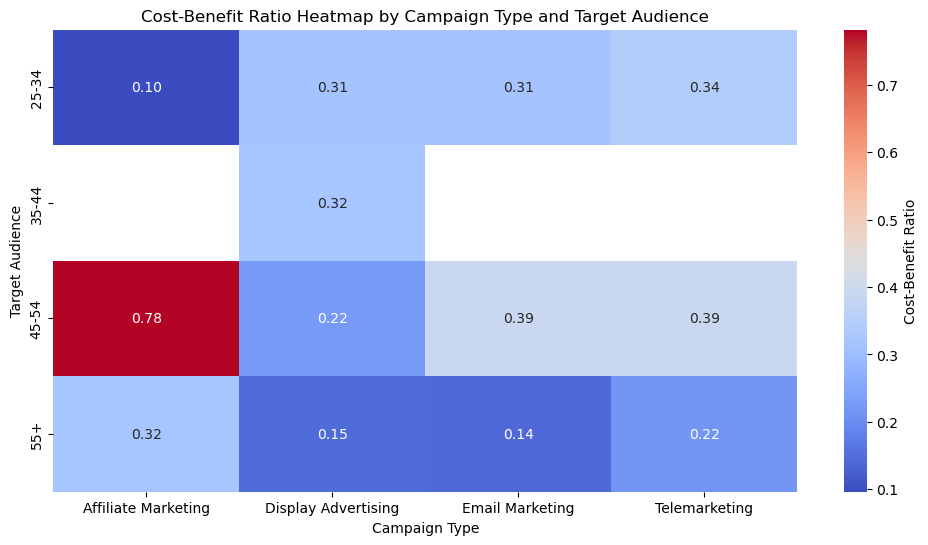

In [343]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming result_df already contains the required data

# Aggregate duplicates by taking the mean of the cost-benefit ratio for each combination
result_df = result_df.groupby(['target_audience', 'campaign_type'], as_index=False)['cost_benefit_ratio'].mean()

# Pivot the result_df to create a matrix suitable for a heatmap
heatmap_data = result_df.pivot(index='target_audience', columns='campaign_type', values='cost_benefit_ratio')

# Drop any rows and columns that contain NaN values
heatmap_data = heatmap_data.dropna(axis=0, how='all')  # Drop rows with all NaN values
heatmap_data = heatmap_data.dropna(axis=1, how='all')  # Drop columns with all NaN values

# Create a heatmap to visualize the cost-benefit ratio
plt.figure(figsize=(12, 6))

# Create the heatmap with annotations
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Cost-Benefit Ratio'}, 
            xticklabels=heatmap_data.columns, yticklabels=heatmap_data.index)

# Set plot title
plt.title('Cost-Benefit Ratio Heatmap by Campaign Type and Target Audience')

# Set axis labels
plt.xlabel('Campaign Type')
plt.ylabel('Target Audience')

# Show the plot
plt.show()
